# Chapter 7

## Preamble

In [100]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pymc3 as pm
import seaborn as sns
import arviz as az
import os
import matplotlib.pyplot as plt

In [8]:
plt.style.use("seaborn-dark")
plt.rcParams["figure.figsize"] = (15, round(15 / np.sqrt(2)))

In [9]:
def data(path):
    BASE = "../external/rethinking/data"  
    return pd.read_csv(f"{BASE}/{path}", sep=";")

## Fetch and preprocess data for 7H1, 7H2

In [10]:
df = data("tulips.csv")
print(f"Rows: {len(df)}")
print(f"Columns: {len(df.columns)}")
df.head()

Rows: 27
Columns: 4


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [43]:
for variable in ["water", "shade", "blooms"]:
    df[f"{variable}_"] = df[variable] - df[variable].mean()
df.head()

,bed,water,shade,blooms,water_,shade_,blooms_
0,a,1,1,0.00,-1.0,-1.0,-128.993704
1,a,1,2,0.00,-1.0,0.0,-128.993704
2,a,1,3,111.04,-1.0,1.0,-17.953704
3,a,2,1,183.47,0.0,-1.0,54.476296
4,a,2,2,59.16,0.0,0.0,-69.833704


In [66]:
def from_spec(df, target, *terms):
    y = df[target].values
    
    columns = []
    for term in terms:
        c = np.ones((len(y), 1))
        for variable in term:
            c *= df[variable].values.reshape((-1, 1))
        columns.append(c)
    return (y, np.concatenate(columns, axis=1))

def create_model(y, X):
    m = pm.Model()
    n = X.shape[1]
    with m: 
        α = pm.Normal("α", mu=0, sd=100)
        β = pm.Normal("β", mu=0, sd=100, shape=n)
        σ = pm.Uniform("σ", lower=0, upper=100)
        μ = α + pm.math.dot(X, β)
        pm.Normal("y", mu=μ, sd=σ, observed=y)
    return m

## Reproducing m7.8 and m7.9

In [80]:
specs = {0: [["water_"], ["shade_"]], 1: [["water_"], ["shade_"], ["water_", "shade_"]]}
models = {}
for (key, spec) in specs.items():
    models[key] = create_model(*from_spec(df, "blooms", *spec))
traces = {}
for (key, model) in models.items():
    traces[key] = pm.sample(model=model, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 12 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3724.33draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.508465260214335, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3434.46draws/s]


In [81]:
for (i, trace) in traces.items():
    print(f"Model {i}")
    display(az.summary(trace))

Model 0


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,126.890,12.842,102.675,151.152,0.173,0.122,5520.0,5520.0,5550.0,4825.0,1.0
β[0],73.932,15.218,45.682,102.871,0.197,0.139,5969.0,5969.0,5990.0,4371.0,1.0
β[1],-40.673,15.238,-68.166,-10.636,0.199,0.141,5877.0,5875.0,5868.0,4810.0,1.0
σ,64.040,9.616,46.975,82.156,0.150,0.111,4120.0,3731.0,4664.0,3178.0,1.0


Model 1


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,127.561,9.872,108.480,145.409,0.114,0.081,7473.0,7473.0,7478.0,5784.0,1.0
β[0],74.541,12.200,51.821,97.267,0.130,0.094,8768.0,8507.0,8812.0,5996.0,1.0
β[1],-41.170,12.426,-64.229,-17.970,0.133,0.098,8738.0,7993.0,8785.0,5607.0,1.0
β[2],-51.582,14.625,-78.690,-23.495,0.160,0.114,8366.0,8278.0,8400.0,5938.0,1.0
σ,51.563,7.963,37.513,66.978,0.108,0.079,5469.0,5048.0,6107.0,4609.0,1.0


## Exercise 7H1

In [82]:
for c in set(df.bed):
    df[c] = np.where(df.bed == c, 1, 0)
df.head()

,bed,water,shade,blooms,water_,shade_,blooms_,b,a,c
0,a,1,1,0.00,-1.0,-1.0,-128.993704,0,1,0
1,a,1,2,0.00,-1.0,0.0,-128.993704,0,1,0
2,a,1,3,111.04,-1.0,1.0,-17.953704,0,1,0
3,a,2,1,183.47,0.0,-1.0,54.476296,0,1,0
4,a,2,2,59.16,0.0,0.0,-69.833704,0,1,0


In [83]:
specs[2] = [["water_"], ["shade_"], ["a"], ["b"], ["c"]]
models[2] = create_model(*from_spec(df, "blooms", *specs[2]))
traces[2] = pm.sample(model=models[2], draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:08<00:00, 1794.70draws/s]
The acceptance probability does not match the target. It is 0.904014678638135, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [84]:
print("Model 2")
display(az.summary(traces[2]));

Model 2


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,95.384,52.772,-5.353,190.132,1.189,0.841,1970.0,1970.0,1966.0,2552.0,1.0
β[0],74.303,14.768,46.924,102.559,0.185,0.133,6364.0,6178.0,6401.0,5041.0,1.0
β[1],-40.900,14.732,-69.783,-14.319,0.186,0.136,6301.0,5897.0,6341.0,4739.0,1.0
β[2],1.622,54.524,-100.961,102.234,1.195,0.845,2082.0,2082.0,2078.0,2809.0,1.0
β[3],45.166,54.820,-55.020,149.128,1.186,0.838,2138.0,2138.0,2138.0,2569.0,1.0
β[4],49.557,54.660,-56.634,146.012,1.203,0.850,2066.0,2066.0,2066.0,2867.0,1.0
σ,61.898,9.700,44.896,80.829,0.183,0.136,2820.0,2550.0,3204.0,2463.0,1.0


## Exercise 7H2

In [91]:
def compute_measures(traces):
    waics = []
    keys = []
    for (key, trace) in traces.items():
        waics.append(az.waic(trace))
        keys.append(key)
    measures = pd.DataFrame({"waic": [w.waic for w in waics],
                             "p_waic": [w.p_waic for w in waics],
                             "keys": keys})
    measures["waic_"] = np.max(measures.waic) - measures.waic
    return measures

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,keys,waic_
0,-152.107756,3.858957,0,5.517625
1,-146.590131,4.378049,1,0.000000
2,-152.208135,5.624124,2,5.618004


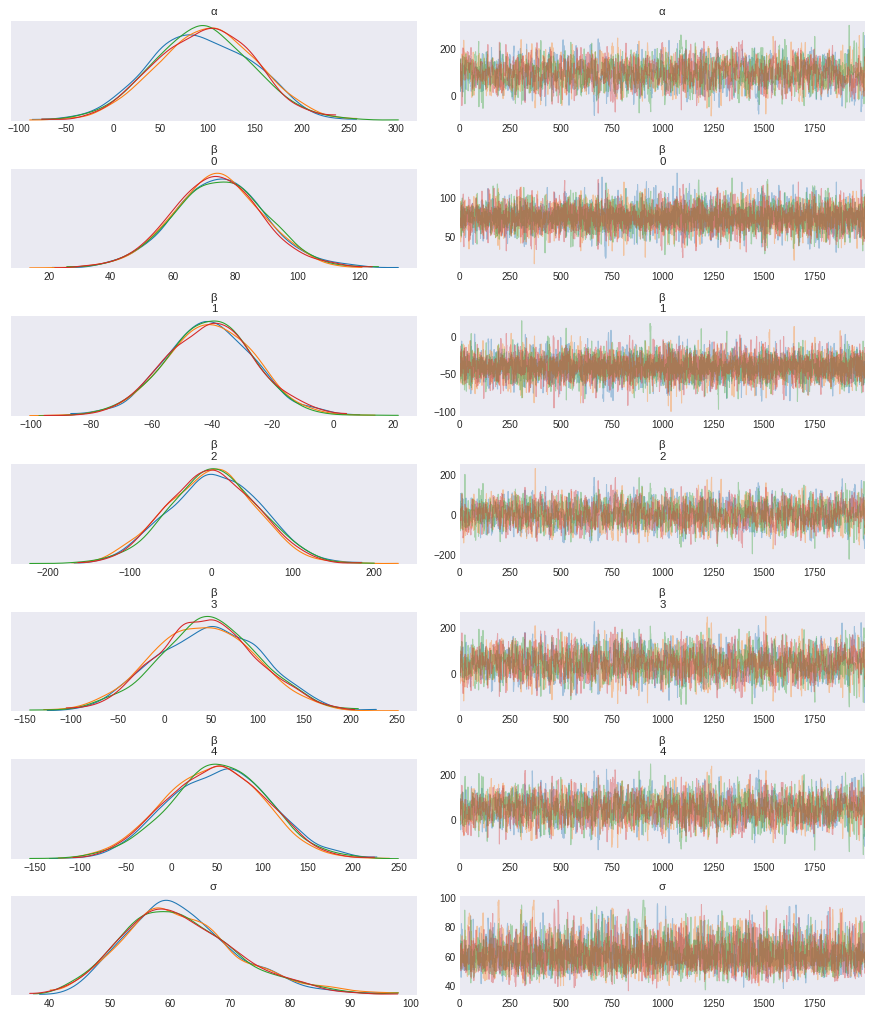

In [92]:
display(compute_measures(traces))
az.plot_trace(traces[2]);

In [94]:
specs[3] = [["water_"], ["shade_"], ["b"], ["c"]]
models[3] = create_model(*from_spec(df, "blooms", *specs[3]))
traces[3] = pm.sample(model=models[3], draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:06<00:00, 2535.07draws/s]


/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,keys,waic_
0,-152.107756,3.858957,0,5.517625
1,-146.590131,4.378049,1,0.000000
2,-152.208135,5.624124,2,5.618004
3,-151.984119,5.531339,3,5.393988


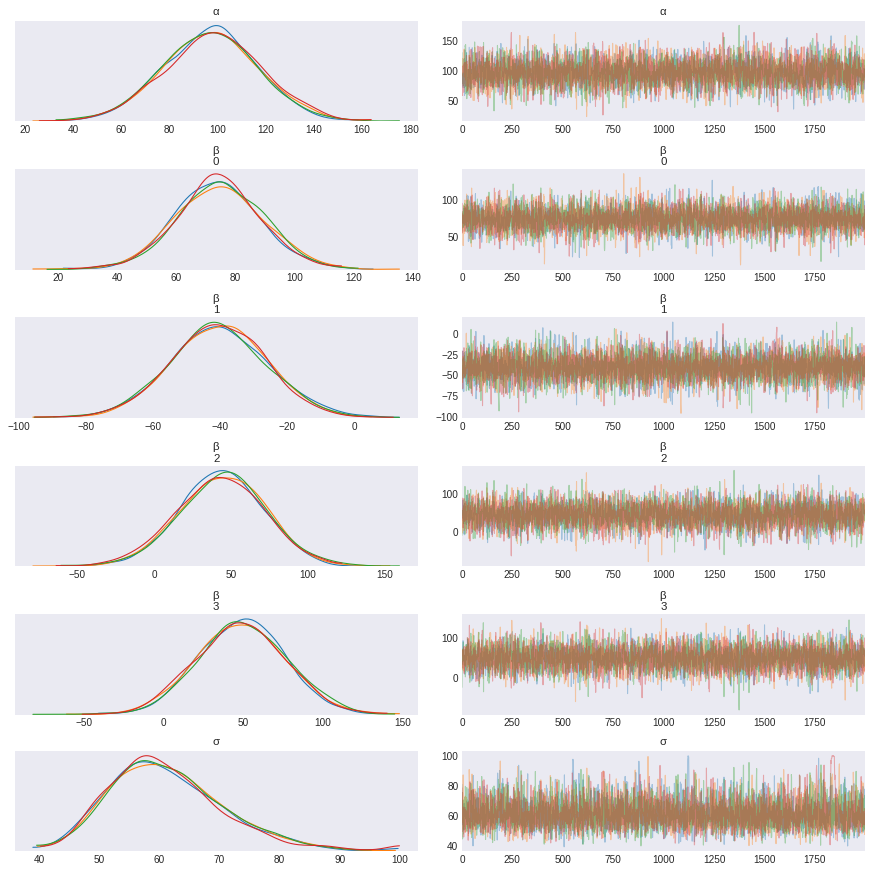

In [95]:
display(compute_measures(traces))
az.plot_trace(traces[3]);

## Exercise 7H3

In [150]:
raw = data("rugged.csv")
print(f"Rows: {len(raw)}")
print(f"Columns: {len(raw.columns)}: {raw.columns}")
raw.head()

Rows: 234
Columns: 51: Index(['isocode', 'isonum', 'country', 'rugged', 'rugged_popw', 'rugged_slope',
       'rugged_lsd', 'rugged_pc', 'land_area', 'lat', 'lon', 'soil', 'desert',
       'tropical', 'dist_coast', 'near_coast', 'gemstones', 'rgdppc_2000',
       'rgdppc_1950_m', 'rgdppc_1975_m', 'rgdppc_2000_m', 'rgdppc_1950_2000_m',
       'q_rule_law', 'cont_africa', 'cont_asia', 'cont_europe', 'cont_oceania',
       'cont_north_america', 'cont_south_america', 'legor_gbr', 'legor_fra',
       'legor_soc', 'legor_deu', 'legor_sca', 'colony_esp', 'colony_gbr',
       'colony_fra', 'colony_prt', 'colony_oeu', 'africa_region_n',
       'africa_region_s', 'africa_region_w', 'africa_region_e',
       'africa_region_c', 'slave_exports', 'dist_slavemkt_atlantic',
       'dist_slavemkt_indian', 'dist_slavemkt_saharan', 'dist_slavemkt_redsea',
       'pop_1400', 'european_descent'],
      dtype='object')


,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


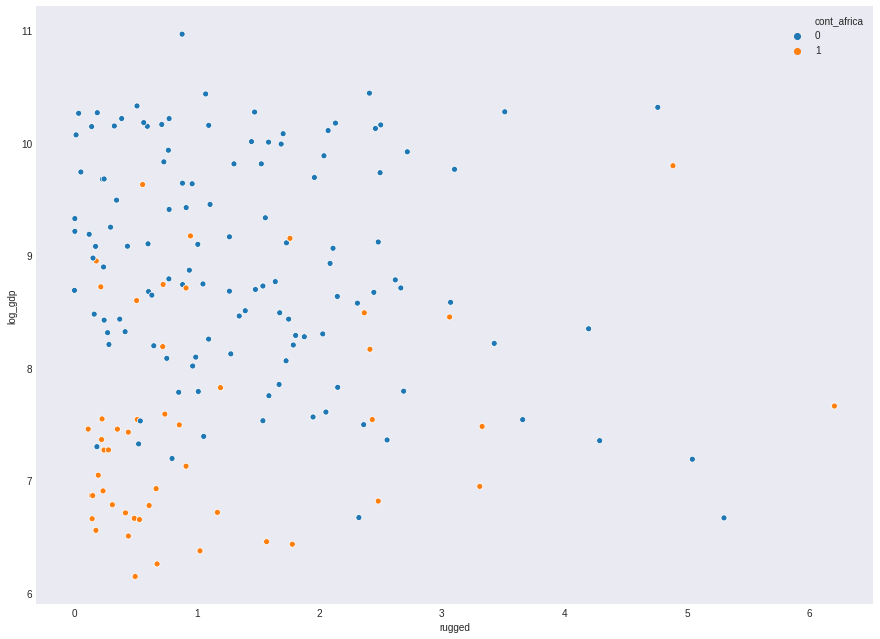

In [153]:
raw["log_gdp"] = np.log(raw.rgdppc_2000)
df = raw[~raw.log_gdp.isna()].copy()
sns.scatterplot(data=df, x="rugged", y="log_gdp", hue="cont_africa", sizes=5)

In [174]:
models = {}
df["rugged_"] = df["rugged"] - df["rugged"].mean()
spec = [["rugged_"], ["cont_africa"], ["rugged_", "cont_africa"]]
models["1 - Seychelles"] = create_model(*from_spec(df, "log_gdp", *spec))
df_ = df[df.country != "Seychelles"]
models["1 - No Seychelles"] = create_model(*from_spec(df_, "log_gdp", *spec))

170 169


In [175]:
traces = {}
for (key, model) in models.items():
    traces[key] = pm.sample(model=model, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:05<00:00, 3136.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:05<00:00, 3128.34draws/s]


In [165]:
estimates = {} 
for (key, model) in models.items():
    estimates[key] = pm.find_MAP(model=model)

logp = -256.08, ||grad|| = 0.091847: 100%|██████████| 34/34 [00:00<00:00, 2493.07it/s]  
logp = -253.4, ||grad|| = 0.23553: 100%|██████████| 35/35 [00:00<00:00, 2469.31it/s]  


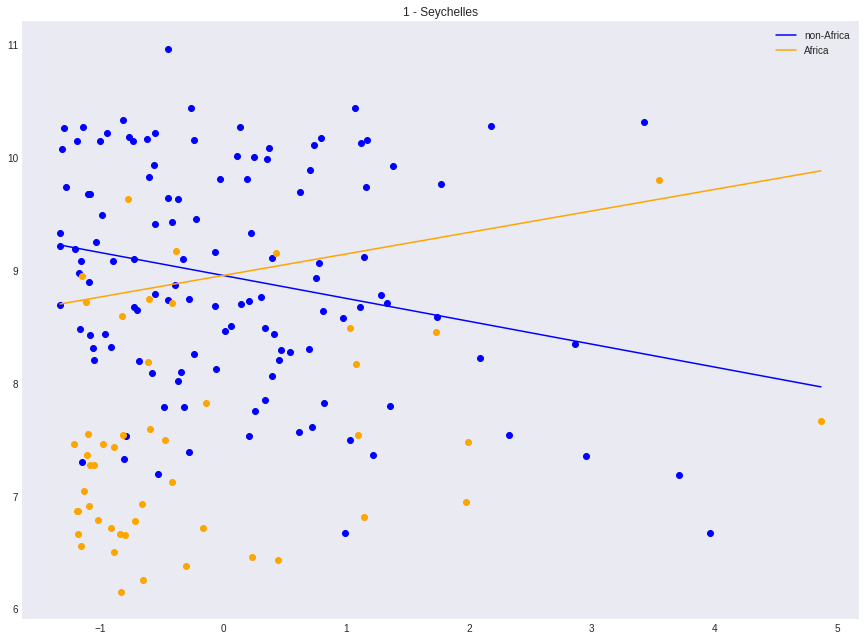

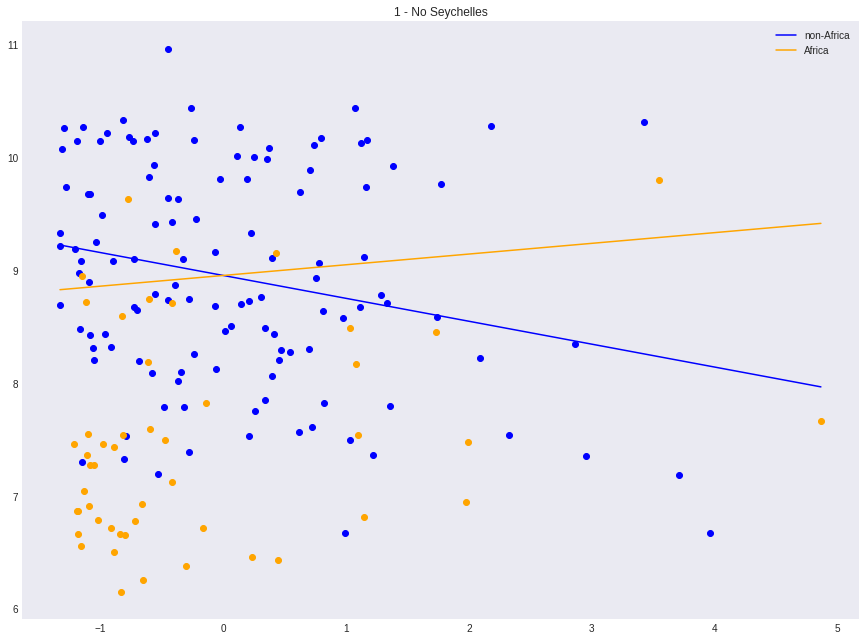

In [182]:
xs = np.linspace(df.rugged_.min(), df.rugged_.max())

for (key, est) in estimates.items():
    plt.plot(df[df.cont_africa==0].rugged_, df[df.cont_africa==0].log_gdp, "go", color="blue")
    plt.plot(df[df.cont_africa==1].rugged_, df[df.cont_africa==1].log_gdp, "go", color="orange")
    ys = est["α"] + est["β"][0] * xs + est["β"][2] * xs
    zs = est["α"] + est["β"][0] * xs
    plt.title(key)
    plt.plot(xs, zs, label="non-Africa", color="blue")
    plt.plot(xs, ys, label="Africa", color="orange")
    plt.legend()
    plt.show()

In [193]:
specs = [[["rugged_"]],
         [["rugged_"], ["cont_africa"]], 
         [["rugged_"], ["cont_africa"], ["rugged_", "cont_africa"]]]

models = {}
traces = {}
for (i, spec) in enumerate(specs):
    models[i] = create_model(*from_spec(df_, "log_gdp", *spec))
    traces[i] = pm.sample(model=models[i], draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:03<00:00, 4100.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3732.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:04<00:00, 3211.05draws/s]


In [195]:
measures = compute_measures(traces)
display(measures);

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1208: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic,p_waic,keys,waic_
0,-268.113920,2.647195,0,36.556223
1,-232.992466,3.810463,1,1.434769
2,-231.557697,4.440885,2,0.000000
